In [1]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Read data

In [2]:
infile = '/g/data/xv83/dbi599/treasury/ffdi_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_19500101-20101231.nc'

In [3]:
ds = xr.open_dataset(infile)

In [4]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:  (lat: 145, lon: 192, time: 55152)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 441kB 1950-01-01T12:00:00 ... 2100-12-31T1...
Data variables:
    FFDI     (lat, lon, time) float32 6GB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(30 April 2019) MD5:e14f55f257cceaf...
    title:                  ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/4553f1df-b8f3-4181-aca8-d617e2bee527
    variable_id:            FFDI
    variant_label:          r1i1p1f1
    version:                v20191115

In [5]:
location_name = 'Adelaide'
lat = -34.92
lon = 138.62

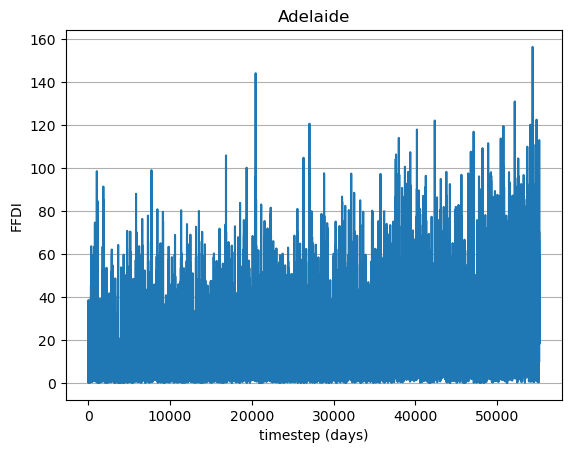

In [6]:
ds_point = ds.sel({'lat': lat, 'lon': lon}, method='nearest')
#ds_point['FFDI'].plot()
plt.plot(ds_point['FFDI'].values)
plt.ylabel('FFDI')
plt.xlabel('timestep (days)')
plt.title(location_name)
plt.grid(axis='y')
plt.show()

### Step 1a: FFDIgt99p

In [7]:
FFDI99p = ds['FFDI'].sel(time=slice('1950-01-01', '2014-12-31')).quantile(0.99, dim='time')
FFDIgt99p = ds['FFDI'] > FFDI99p
FFDIgt99p = FFDIgt99p.resample({'time': 'YE'}).sum('time', keep_attrs=True)
FFDIgt99p.name = 'FFDIgt99p'

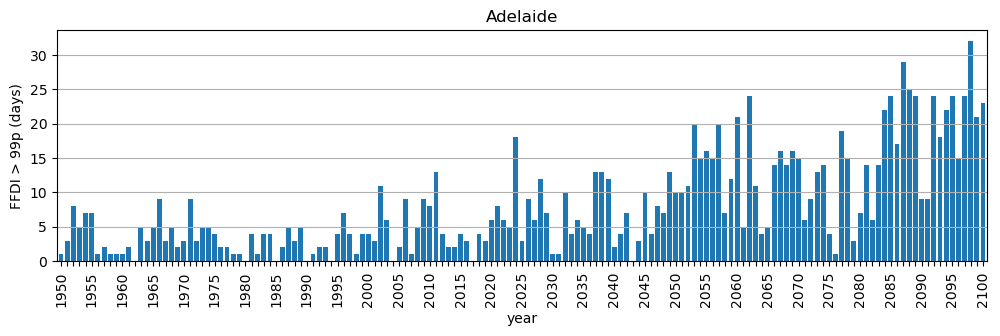

In [8]:
FFDIgt99p_point = FFDIgt99p.sel({'lat': lat, 'lon': lon}, method='nearest')
FFDIgt99p_point_ds = FFDIgt99p_point.to_series()
FFDIgt99p_point_ds.index = FFDIgt99p_point_ds.index.year
ax = FFDIgt99p_point_ds.plot.bar(figsize=[12, 3], width=0.8)
ax.set_ylabel('FFDI > 99p (days)')
ax.set_xlabel('year')
ax.set_title(location_name)
plt.grid(axis='y')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.show()

### Step 1b: FFDIx

In [9]:
FFDIx = ds['FFDI'].resample({'time': 'YE'}).max('time', keep_attrs=True)
FFDIx.name = 'FFDIx'
FFDIx = FFDIx.compute()

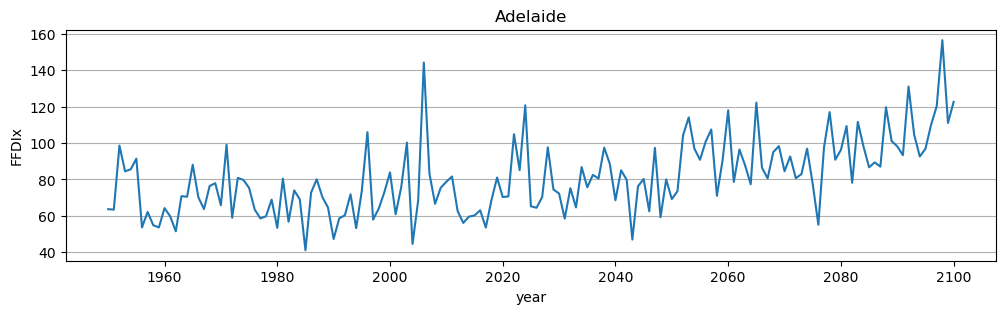

In [12]:
FFDIx_point = FFDIx.sel({'lat': lat, 'lon': lon}, method='nearest')
FFDIx_point_ds = FFDIx_point.to_series()
FFDIx_point_ds.index = FFDIx_point_ds.index.year
ax = FFDIx_point_ds.plot.line(figsize=[12, 3])
ax.set_ylabel('FFDIx')
ax.set_xlabel('year')
ax.set_title(location_name)
plt.grid(axis='y')
plt.show()

In [13]:
#ffdix_clim = ffdix.sel(time=slice('1950-01-01', '2014-12-31')).mean('time', keep_attrs=True)
#ffdix_anomaly = ffdix - ffdix_clim
#ffdix_anomaly_point = ffdix_anomaly.sel({'lat': lat, 'lon': lon}, method='nearest')
#ffdix_anomaly_point.plot()

## Step 2: Read shapefiles

In [14]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [15]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [16]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [17]:
states_gp = states_gp[:-2]

In [18]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [19]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [20]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [21]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [22]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [23]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [24]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [25]:
type(states_regions)

regionmask.core.regions.Regions

In [26]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


## Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [27]:
frac = states_regions.mask_3D_frac_approx(FFDIx)

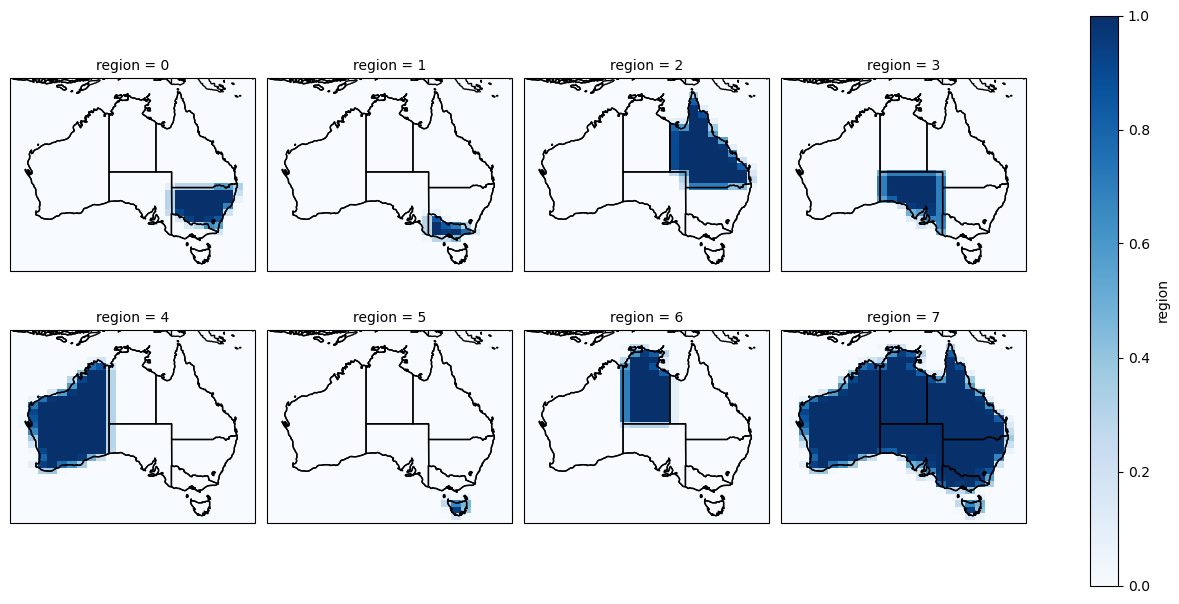

In [28]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

## Step 4: Calculate a (weighted) regional mean

In [30]:
weights = np.cos(np.deg2rad(FFDIx['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

### Step 4a: FFDIgt99p

In [31]:
FFDIgt99p_spatial_means = FFDIgt99p.weighted(frac * weights).mean(dim=("lat", "lon"))

In [34]:
FFDIgt99p_df = FFDIgt99p_spatial_means.to_pandas()
FFDIgt99p_df.columns = FFDIgt99p_spatial_means['abbrevs']
FFDIgt99p_df.index = FFDIgt99p_df.index.year
FFDIgt99p_df = FFDIgt99p_df.round(decimals=2)

In [35]:
FFDIgt99p_df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950,0.82,0.35,0.64,0.53,0.56,1.20,0.43,0.58
1951,1.73,1.05,3.37,4.32,5.22,1.25,5.76,4.26
1952,9.12,6.93,7.38,6.26,5.58,1.40,8.83,7.02
1953,7.28,10.56,2.54,2.73,2.12,5.26,0.84,2.88
1954,11.08,7.58,7.22,6.39,4.16,0.91,4.42,5.97
...,...,...,...,...,...,...,...,...
2096,17.81,7.53,18.77,13.33,16.60,23.37,20.82,17.33
2097,29.09,22.15,27.39,18.00,18.84,25.57,24.21,22.82
2098,20.75,25.68,17.19,20.82,19.33,40.78,15.71,18.92


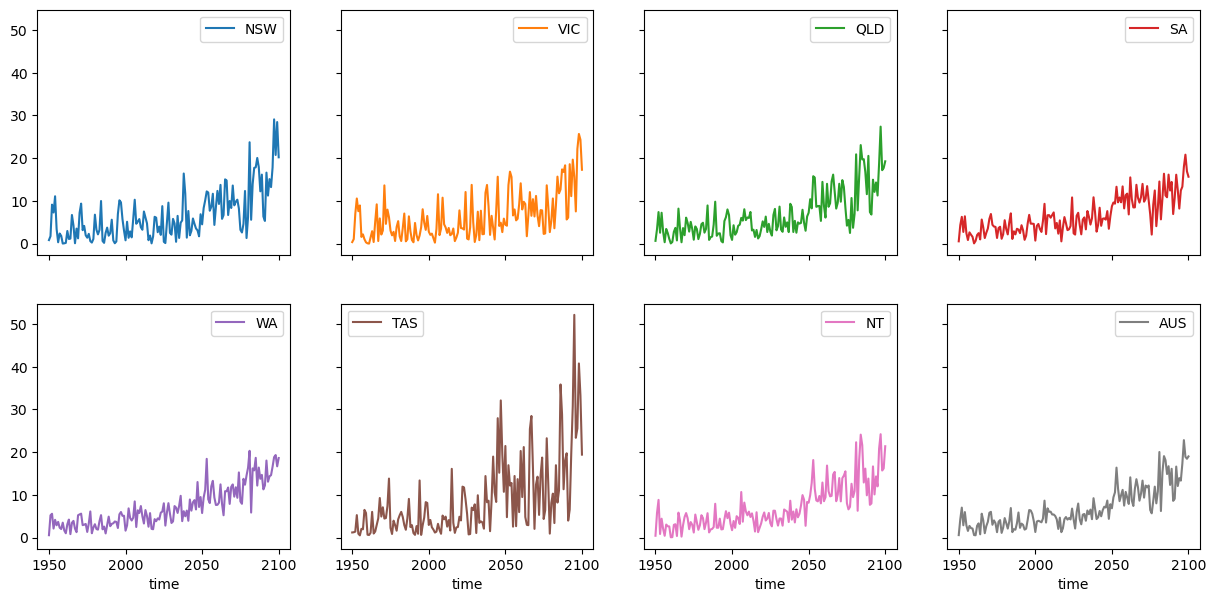

In [36]:
FFDIgt99p_df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [37]:
FFDIgt99p_outfile = '/g/data/xv83/dbi599/treasury/FFDIgt99p_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1950-2100.csv'

In [38]:
FFDIgt99p_df.to_csv(FFDIgt99p_outfile)

### Step 4b: FFDIx

In [39]:
FFDIx_spatial_means = FFDIx.weighted(frac * weights).mean(dim=("lat", "lon"))

In [40]:
FFDIx_df = FFDIx_spatial_means.to_pandas()
FFDIx_df.columns = FFDIx_spatial_means['abbrevs']
FFDIx_df.index = FFDIx_df.index.year
FFDIx_df = FFDIx_df.round(decimals=1)

In [41]:
FFDIx_df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950,56.9,34.2,56.8,88.8,83.4,8.4,68.4,70.6
1951,65.3,41.3,73.9,137.6,120.8,7.7,98.1,99.3
1952,80.8,60.8,78.3,138.0,121.9,7.1,106.9,104.4
1953,78.3,60.3,68.0,112.8,104.3,9.4,78.2,87.8
1954,81.6,70.6,76.5,125.5,110.3,6.7,90.0,96.0
...,...,...,...,...,...,...,...,...
2096,102.1,62.3,95.7,167.3,138.3,11.3,125.2,123.0
2097,98.9,80.9,102.6,157.4,140.6,12.0,121.8,123.7
2098,99.1,77.3,89.3,164.2,146.9,13.6,115.7,122.5


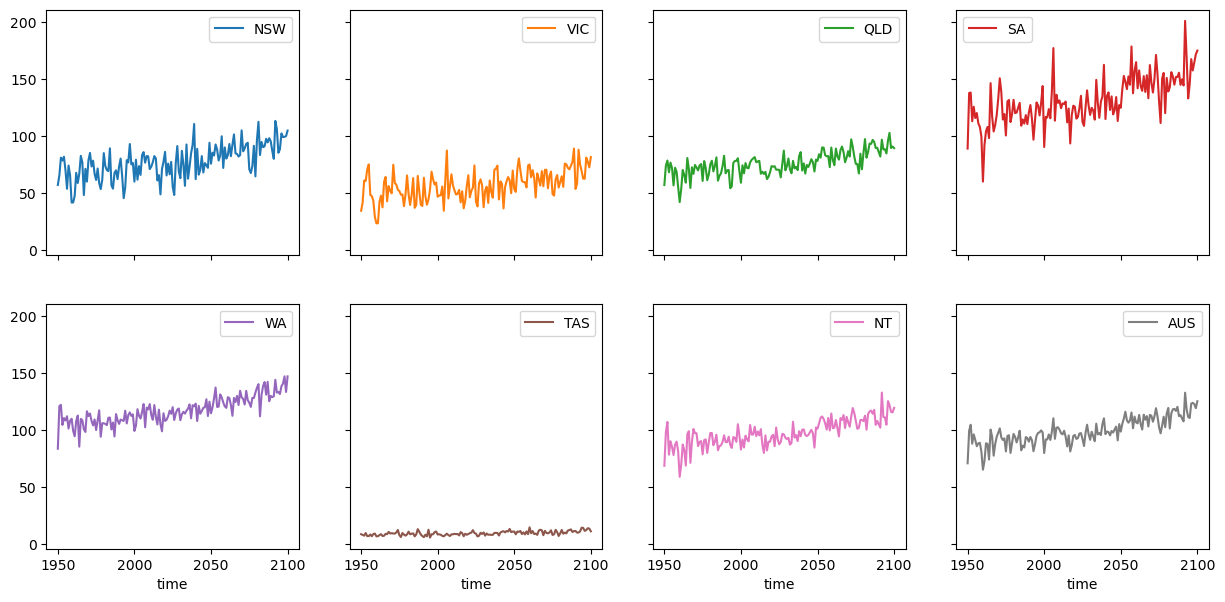

In [42]:
FFDIx_df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [43]:
FFDIx_outfile = '/g/data/xv83/dbi599/treasury/FFDIx_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1950-2100.csv'

In [44]:
FFDIx_df.to_csv(FFDIx_outfile)